# ***Character-wise Encoding, RNN model***

**Contents**

1.   Mounting Drive
2.   Importing Libraries
3.   Loading Dataset
4.   Tokenization
5.   Creating features and labels for model building
6.   One-hot encoding of characters
7.   Splitting dataset as Train, Validation sets
8.   Model Building
9.   Generating new songs
10.  BLEU scores for each model
11.  Plots for BLEU scores



**Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
from time import time
import time
import random
from statistics import median
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Bidirectional, Dense, Dropout, Masking, Embedding
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

**Loading Ed-Sheeran songs dataset**

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ed_sheeran.csv',header=None,names=['Title','Link','Lyrics'])

#Removing rows which have empty lyrics
data = data[data['Lyrics'].notna()].reset_index(drop=True)

#Removing Duplicate rows and unneccessary columns
data = pd.DataFrame(data['Lyrics'].unique(),columns=['Lyrics'])

data.head(5)

,Lyrics
0,"Hey, hey, hey, hey, Hey, hey, hey, hey, Hey, ..."
1,The club isn't the best place to find a lover...
2,"I found a love for me, Darling, just dive rig..."
3,"Loving can hurt, Loving can hurt sometimes, B..."
4,When your legs don't work like they used to b...


In [4]:
#Creating list of all songs
lyrics = list(data['Lyrics'].apply(str))

**Median length of song**

In [5]:
lyric_length = round(median([len(lyrics[x]) for x in range(len(lyrics))])/100)*100
lyric_length

1500

**Character level tokenization of songs**

In [6]:
tokenizer = Tokenizer(lower = False, char_level=True)
tokenizer.fit_on_texts(lyrics)

In [7]:
#Converting each song into list of tokens
sequences = tokenizer.texts_to_sequences(lyrics)

In [8]:
lyrics[1][:300]

' The club isn\'t the best place to find a lover, So the bar is where I go, Me and my friends at the table doing shots, Drinking fast, and then we talk slow And you come over and start up a conversation with just me, And trust me, I\'ll give it a chance now, Take my hand, stop, Put "Van the Man" on the'

In [9]:
print(sequences[1][:300])

[1, 28, 9, 2, 1, 23, 8, 14, 22, 1, 7, 10, 5, 21, 4, 1, 4, 9, 2, 1, 22, 2, 10, 4, 1, 26, 8, 6, 23, 2, 1, 4, 3, 1, 20, 7, 5, 13, 1, 6, 1, 8, 3, 25, 2, 12, 11, 1, 31, 3, 1, 4, 9, 2, 1, 22, 6, 12, 1, 7, 10, 1, 17, 9, 2, 12, 2, 1, 19, 1, 18, 3, 11, 1, 35, 2, 1, 6, 5, 13, 1, 16, 15, 1, 20, 12, 7, 2, 5, 13, 10, 1, 6, 4, 1, 4, 9, 2, 1, 4, 6, 22, 8, 2, 1, 13, 3, 7, 5, 18, 1, 10, 9, 3, 4, 10, 11, 1, 43, 12, 7, 5, 24, 7, 5, 18, 1, 20, 6, 10, 4, 11, 1, 6, 5, 13, 1, 4, 9, 2, 5, 1, 17, 2, 1, 4, 6, 8, 24, 1, 10, 8, 3, 17, 1, 27, 5, 13, 1, 15, 3, 14, 1, 23, 3, 16, 2, 1, 3, 25, 2, 12, 1, 6, 5, 13, 1, 10, 4, 6, 12, 4, 1, 14, 26, 1, 6, 1, 23, 3, 5, 25, 2, 12, 10, 6, 4, 7, 3, 5, 1, 17, 7, 4, 9, 1, 37, 14, 10, 4, 1, 16, 2, 11, 1, 27, 5, 13, 1, 4, 12, 14, 10, 4, 1, 16, 2, 11, 1, 19, 21, 8, 8, 1, 18, 7, 25, 2, 1, 7, 4, 1, 6, 1, 23, 9, 6, 5, 23, 2, 1, 5, 3, 17, 11, 1, 28, 6, 24, 2, 1, 16, 15, 1, 9, 6, 5, 13, 11, 1, 10, 4, 3, 26, 11, 1, 52, 14, 4, 1, 51, 60, 6, 5, 1, 4, 9, 2, 1, 35, 6, 5, 51, 1, 3, 5, 1, 4, 9,

In [10]:
#Dictionary of unique tokens
idx_char = tokenizer.index_word

**Creating Features and Labels for Model building**

In [11]:
features = []
labels = []

training_length = 50

# Iterate through teach tokenized song
for seq in sequences:

    # Create multiple training examples from each sequence
    for i in range(training_length, len(seq)):
        
        # Extract the features and label
        extract = seq[i - training_length:i + 1]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])
        
features = np.array(features)

In [12]:
features

array([[ 1, 39,  2, ...,  2, 15, 11],
       [39,  2, 15, ..., 15, 11,  1],
       [ 2, 15, 11, ..., 11,  1,  9],
       ...,
       [ 4,  3,  1, ..., 12,  3, 14],
       [ 3,  1,  8, ...,  3, 14, 22],
       [ 1,  8, 14, ..., 14, 22,  8]])

In [13]:
# Unique characters in vocabulary
num_chars = len(idx_char)+1

# Empty array to hold labels
label_array = np.zeros((len(features),num_chars))

# One-hot encoding for labels
for example_index, word_index in enumerate(labels):
    label_array[example_index, word_index]=1

label_array.shape

(180084, 77)

**Splitting dataset into Train and Validation datasets**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, label_array, test_size=0.2, random_state=0)

In [15]:
#Function for creating network structure, training the model
def model_build (lr_value,bs_value,results):

    model = Sequential()
    # Embedding layer
    model.add(
        Embedding(input_dim=num_chars,
              input_length = training_length,
              output_dim=num_chars,
              weights=None,
              trainable=False))

    # Masking layer for pre-trained embeddings
    model.add(Masking(mask_value=0.0))

    # Recurrent layer
    model.add(SimpleRNN(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

    # Fully connected layer
    model.add(Dense(64, activation='relu'))

    # Dropout for regularization
    model.add(Dropout(0.1))

    # Output layer
    model.add(Dense(num_chars, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(lr=lr_value), loss='categorical_crossentropy', metrics=['accuracy'])
    
    #Setting path for storing weights for exery 5 epochs
    filepath="/content/drive/My Drive/Colab Notebooks/char-RNN-weights-{}-{}".format(lr_value,bs_value)
    filepath=filepath+"-{epoch:02d}.hdf5"
    checkpoint = ModelCheckpoint(filepath, verbose=1, period=5, save_best_only=False)
    
    #Calling function for saving epoch times
    time_callback = TimeHistory()

    print("\n----------BUILDING MODEL with lr-{} and bs-{}----------\n".format(lr_value,bs_value))
    
    #Building the model
    model.fit(X_train, y_train,
              batch_size=bs_value,
              epochs=30,
              verbose=0,
              validation_data=(X_test, y_test),
              callbacks=[checkpoint, time_callback])
    
    #time for epochs
    times = time_callback.times
    times = Cumulative(times)
    times = [round(times[x]/60,2) for x in range(len(times)) if (x+1)%5==0]
    for t,k in zip([5,10,15,20,25,30],[0,1,2,3,4,5]):
        results.loc[len(results)] = [lr_value,bs_value,t,times[k]]

In [16]:
#Class for storing time for epochs
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [17]:
#Function for converting list to cumulative sum of list
def Cumulative(lists):  
    cu_list = []
    length = len(lists)  
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]  
    return cu_list[1:]

In [18]:
#Storing the model results in 'results' dataframe
results = pd.DataFrame(columns = ["learning_rate","batch_size","epochs","time"])

#Various hyper parameter combinations for learning rate and batch_size
for a,b in zip([0.01,0.01,0.001,0.0001],[128,256,128,128]):
    model_build(a,b,results)

#Saving the file_name of intermediate model weights files
results['file_name']=results.apply(lambda row : "char-RNN-weights-{}-{}-{:02d}.hdf5".format(row.learning_rate, int(row.batch_size), int(row.epochs)), axis=1)


----------BUILDING MODEL with lr-0.01 and bs-128----------


Epoch 00005: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-128-05.hdf5

Epoch 00010: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-128-10.hdf5

Epoch 00015: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-128-15.hdf5

Epoch 00020: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-128-20.hdf5

Epoch 00025: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-128-25.hdf5

Epoch 00030: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-128-30.hdf5

----------BUILDING MODEL with lr-0.01 and bs-256----------


Epoch 00005: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-256-05.hdf5

Epoch 00010: saving model to /content/drive/My Drive/Colab Notebooks/char-RNN-weights-0.01-256-10.hdf5

Epoch 00015: saving model to /content/drive/M

In [19]:
results

,learning_rate,batch_size,epochs,time,file_name
0,0.0100,128.0,5.0,6.51,char-RNN-weights-0.01-128-05.hdf5
1,0.0100,128.0,10.0,12.94,char-RNN-weights-0.01-128-10.hdf5
2,0.0100,128.0,15.0,19.41,char-RNN-weights-0.01-128-15.hdf5
3,0.0100,128.0,20.0,25.84,char-RNN-weights-0.01-128-20.hdf5
4,0.0100,128.0,25.0,32.25,char-RNN-weights-0.01-128-25.hdf5
5,0.0100,128.0,30.0,38.63,char-RNN-weights-0.01-128-30.hdf5
6,0.0100,256.0,5.0,3.31,char-RNN-weights-0.01-256-05.hdf5
7,0.0100,256.0,10.0,6.55,char-RNN-weights-0.01-256-10.hdf5
8,0.0100,256.0,15.0,9.78,char-RNN-weights-0.01-256-15.hdf5
9,0.0100,256.0,20.0,13.03,char-RNN-weights-0.01-256-20.hdf5


**Generating a song for all the models created for various hyper parameters**

In [20]:
#Function to generate new song using new model
def generate(model):
    generated=''
    combined_lyrics = ' '.join(lyrics)
    random.seed(1)
    start_index=random.randint(0,len(combined_lyrics)-training_length-1)
    sent=combined_lyrics[start_index:start_index+training_length]
    generated+=sent
    for i in range(lyric_length):
        x_sample=generated[i:i+training_length]
        x=np.zeros((1,training_length))
        for j in range(training_length):
            x[0,j]=list(idx_char.values()).index(x_sample[j])+1
        probs=model.predict(x)
        probs=np.reshape(probs,probs.shape[1])
        np.random.seed(0)
        #Picking a character based on probability distribution
        ix=np.random.choice(range(num_chars),p=probs.ravel())
        generated+=idx_char[ix]
    return(generated)

In [21]:
#Creating a new column in results dataframe with the generated song
results['generated'] = results.apply(lambda row : generate(load_model('/content/drive/My Drive/Colab Notebooks/' + row.file_name)), axis=1)

In [22]:
results['generated'][1]

" these things I've done, I will love you better now you don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't d

**BLEU score using Validation data as ground truth for 1,2,3,4 grams**

In [23]:
#Creating list of reference sequences
reference=[]
for a in range(X_test.shape[0]):
    ref=''
    for b in range(X_test.shape[1]):
        ref=ref+idx_char[X_test[a][b]]
    reference.append(ref.split())

In [24]:
reference[0]

['nt',
 'to',
 'UNI,',
 "I've",
 'been',
 'sofa',
 'surfing',
 'with',
 'a',
 'rucksack,']

In [25]:
#Function to find BLEU score
def bleu_score(generated,gram):
    references = [reference]
    candidates = [generated.split()]
    t = [0,0,0,0]
    t[gram-1]=1
    score = corpus_bleu(references, candidates, weights=tuple(t))
    return score

In [26]:
#Creating new columns for BLUE score for 1,2,3,4 grams
results['blue-1']=results['generated'].apply(lambda x: bleu_score(x,1))
results['blue-2']=results['generated'].apply(lambda x: bleu_score(x,2))
results['blue-3']=results['generated'].apply(lambda x: bleu_score(x,3))
results['blue-4']=results['generated'].apply(lambda x: bleu_score(x,4))

In [27]:
results.to_csv("/content/drive/My Drive/Colab Notebooks/char-RNN-results.csv",index=None)
results

,learning_rate,batch_size,epochs,time,file_name,generated,blue-1,blue-2,blue-3,blue-4
0,0.0100,128.0,5.0,6.51,char-RNN-weights-0.01-128-05.hdf5,"these things I've done, I will love you bette...",0.057471,0.042308,0.027027,0.019380
1,0.0100,128.0,10.0,12.94,char-RNN-weights-0.01-128-10.hdf5,"these things I've done, I will love you bette...",0.050000,0.042471,0.027132,0.019455
2,0.0100,128.0,15.0,19.41,char-RNN-weights-0.01-128-15.hdf5,"these things I've done, I will love you bette...",0.060071,0.035461,0.024911,0.017857
3,0.0100,128.0,20.0,25.84,char-RNN-weights-0.01-128-20.hdf5,"these things I've done, I will love you bette...",0.230769,0.210526,0.162162,0.111111
4,0.0100,128.0,25.0,32.25,char-RNN-weights-0.01-128-25.hdf5,"these things I've done, I will love you bette...",0.065217,0.058394,0.044118,0.029630
5,0.0100,128.0,30.0,38.63,char-RNN-weights-0.01-128-30.hdf5,"these things I've done, I will love you bette...",0.900000,0.888889,0.750000,0.571429
6,0.0100,256.0,5.0,3.31,char-RNN-weights-0.01-256-05.hdf5,"these things I've done, I will love you bette...",0.040089,0.024554,0.015660,0.011211
7,0.0100,256.0,10.0,6.55,char-RNN-weights-0.01-256-10.hdf5,"these things I've done, I will love you bette...",0.066667,0.040179,0.026906,0.018018
8,0.0100,256.0,15.0,9.78,char-RNN-weights-0.01-256-15.hdf5,"these things I've done, I will love you bette...",0.043732,0.023392,0.017595,0.011765
9,0.0100,256.0,20.0,13.03,char-RNN-weights-0.01-256-20.hdf5,"these things I've done, I will love you bette...",0.050000,0.038610,0.027132,0.019455


**Plot for BLEU score(2-grams) vs epochs with parameters as lr=0.01, batch_size=128**

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


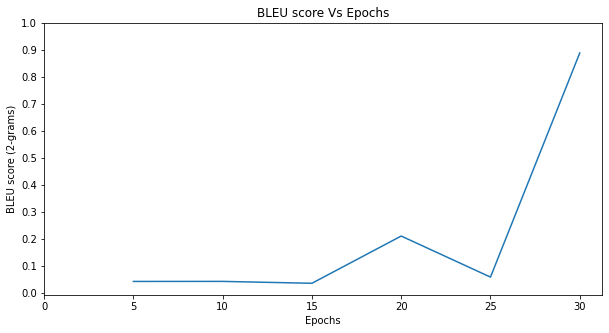

In [29]:
plt.figure(figsize=(10,5))
sns.lineplot(x='epochs', y='blue-2',  
             data=results[(results['learning_rate']==0.01) & (results['batch_size']==128)], palette = "Dark2")
plt.title('BLEU score Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLEU score (2-grams)')
plt.xticks(range(0,31,5))
plt.yticks([0.1*x for x in range(0,11)])
plt.savefig("/content/drive/My Drive/Colab Notebooks/char-RNN-p1.png")
plt.show()

- Increase in BLEU score with increase in epochs

**Plot for BLEU score(2-grams) vs Batch size with parameters lr=0.01 and epochs=30**

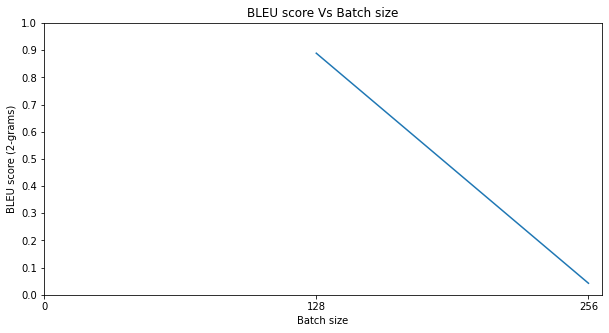

In [30]:
plt.figure(figsize=(10,5))
sns.lineplot(x='batch_size', y='blue-2',  
             data=results[(results['learning_rate']==0.01) & (results['epochs']==30)], palette = "Dark2")
plt.title('BLEU score Vs Batch size')
plt.xlabel('Batch size')
plt.ylabel('BLEU score (2-grams)')
plt.xticks(range(0,257,128))
plt.yticks([0.1*x for x in range(0,11)])
plt.savefig("/content/drive/My Drive/Colab Notebooks/char-RNN-p2.png")
plt.show()

- Decrease in BLEU score with increase in batch size